### **AI project**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import sys
# sys.path.append('/content/drive/MyDrive/AI')

In [ ]:
# from erfnet import ERFNet

In [ ]:
!pip install ood_metrics

In [ ]:
# import erfnet
# !git clone https://github.com/shyam671/AnomalySegmentation_CourseProjectBaseCode.git

Cloning into 'AnomalySegmentation_CourseProjectBaseCode'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 61 (delta 3), reused 3 (delta 3), pack-reused 51
Receiving objects: 100% (61/61), 21.48 MiB | 31.74 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
# !git clone https://github.com/SegmentMeIfYouCan/road-anomaly-benchmark.git

Cloning into 'road-anomaly-benchmark'...
remote: Enumerating objects: 868, done.
remote: Counting objects: 100% (868/868), done.
remote: Compressing objects: 100% (388/388), done.
remote: Total 868 (delta 541), reused 802 (delta 477), pack-reused 0
Receiving objects: 100% (868/868), 2.72 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (541/541), done.


In [ ]:
# !git clone https://github.com/gpleiss/temperature_scaling.git

In [ ]:
! pip install wget
# !wget https://github.com/shyam671/AnomalySegmentation_CourseProjectBaseCode/raw/main/trained_models/erfnet_pretrained.pth




  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=3350aae45477ad2a8279f9369ad42a05f1b152b8c90ab3be722dfc963db720cf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import os
import sys
shared_folder_path = '/content/drive/MyDrive/temperature_scaling'
files_in_shared_folder = os.listdir(shared_folder_path)
sys.path.append('/content/drive/MyDrive/temperature_scaling')

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available.")

GPU: Tesla T4


Model and weights LOADED successfully
AUPRC score : 1.9999022378683857
FPR@TPR95 : 95.13079378537104


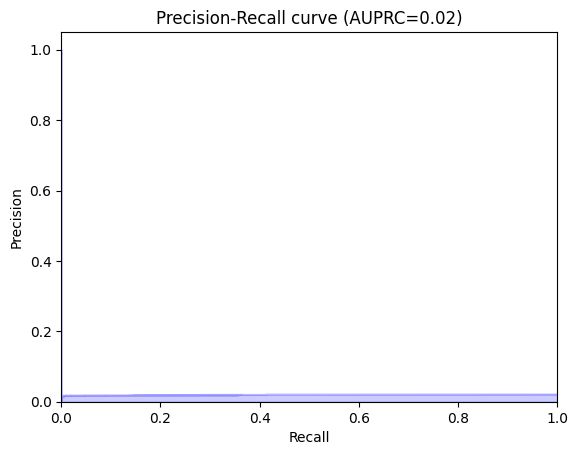

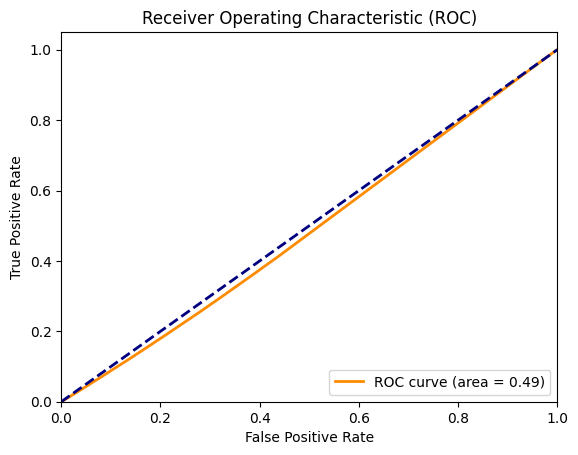

In [ ]:
import matplotlib.pyplot as plt
import sys
import wget

sys.path.append('/content/drive/MyDrive/AnomalySegmentation_CourseProjectBaseCode/eval')
sys.path.append('/content/drive/MyDrive/road-anomaly-benchmark-master/methods')
sys.path.append('/content/drive/MyDrive/temperature_scaling/methods')

import temperature_scaling
from temperature_scaling import ModelWithTemperature
import baselines
from iouEval import *
import eval_iou
from baselines import *
import os
import cv2
import glob
import torch
import random
from PIL import Image
import numpy as np
import erfnet
from erfnet import ERFNet
import os.path as osp
from argparse import ArgumentParser
from ood_metrics import fpr_at_95_tpr, calc_metrics, plot_roc, plot_pr, plot_barcode
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

NUM_CHANNELS = 3
NUM_CLASSES = 20
# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Define the plot function
def plot_pr_roc_curve(val_label, val_out, **kwargs):
    prc_auc = kwargs.get('prc_auc', None)

    # Plot PR curve
    precision, recall, _ = precision_recall_curve(val_label, val_out)
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (AUPRC={0:0.2f})'.format(prc_auc))
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(val_label, val_out)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


def visualize_segmentation(images, labels, predictions):
    num_images = len(images)
    if num_images == 1:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes = axes.reshape(1, -1)  # Reshape axes to be a 2-dimensional array
    else:
        fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 4))

    for i in range(num_images):
        if num_images == 1:
            image = images[i].permute(1, 2, 0)  # Permute dimensions for visualization
            image = image / 255.0  # Normalize pixel values to [0, 1]
            axes[0, 0].imshow(image)
            axes[0, 0].set_title('Image')
            axes[0, 1].imshow(labels[i], cmap='gray')
            axes[0, 1].set_title('Ground Truth')
            axes[0, 2].imshow(predictions[i], cmap='gray')
            axes[0, 2].set_title('Prediction')
        else:
            image = images[i].permute(1, 2, 0)  # Permute dimensions for visualization
            image = image / 255.0  # Normalize pixel values to [0, 1]
            axes[i, 0].imshow(image)
            axes[i, 0].set_title('Image')
            axes[i, 1].imshow(labels[i], cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 2].imshow(predictions[i], cmap='gray')
            axes[i, 2].set_title('Prediction')

    plt.tight_layout()
    plt.show()




def main():

    anomaly_score_list = []
    ood_gts_list = []
    means_iou = []
    iou_per_class = []

    input = "/content/drive/MyDrive/Dataset/Validation_Dataset/Validation_Dataset/fs_static/images/*.jpg"
    input_labels_masks = "/content/drive/MyDrive/Dataset/Validation_Dataset/Validation_Dataset/fs_static/labels_masks/*.png"
    image_files = glob.glob(input)
    label_files = glob.glob(input_labels_masks)
    loadDir = '/content/drive/MyDrive/AnomalySegmentation_CourseProjectBaseCode/trained_models'
    loadWeights = '/content/drive/MyDrive/AnomalySegmentation_CourseProjectBaseCode/trained_models/erfnet_pretrained.pth'
    loadModel = '/content/drive/MyDrive/AnomalySegmentation_CourseProjectBaseCode/eval/erfnet.py'
    subset = 'val'
    batch_size = 1
    cpu = False

    if not os.path.exists('results.txt'):
        open('results.txt', 'w').close()
    file = open('results.txt', 'a')

    modelpath = loadModel
    weightspath = loadWeights

    # print("Loading model: " + modelpath)
    # print("Loading weights: " + weightspath)

    model = ERFNet(NUM_CLASSES)

    if (not cpu):
      model = torch.nn.DataParallel(model).cuda()


    def load_my_state_dict(model, state_dict):  # custom function to load model when not all dict elements
        own_state = model.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                if name.startswith("module."):
                    own_state[name.split("module.")[-1]].copy_(param)
                else:
                    # print(name, " not loaded")
                    continue
            else:
                own_state[name].copy_(param)
        return model

    model = load_my_state_dict(model, torch.load(weightspath, map_location=lambda storage, loc: storage))
    print("Model and weights LOADED successfully")
    model.eval()


    # msp = Max_softmax(model)
    ent_max = Entropy_max(model)

    # print = (len(label_files), len(image_files))
    images_list = []

    for idx, path in enumerate(image_files):
      image = Image.open(path).convert('RGB')
      image = np.array(image)
      images_list.append(image)

      # print(path)
      # print(f"Image {idx + 1}: {path}")
      label_path = label_files[idx]
      images = torch.from_numpy(np.array(Image.open(path).convert('RGB'))).unsqueeze(0).float()
      images = images.permute(0, 3, 1, 2)
      label_mask = torch.from_numpy(np.array(Image.open(label_path))).unsqueeze(0).float()
      label_mask = label_mask.unsqueeze(0)
      label_mask = label_mask.permute(0, 3, 1, 2)
      with torch.no_grad():
        result = model(images)

      # anomaly_result = msp.anomaly_score(images) # Max_Softmax_Probability(MSP) score analysis function
      anomaly_result = ent_max.anomaly_score(images)   #Max_Entropy score analysis function

      # logit_scores = result.squeeze(0).data.cpu().numpy()
      # print("Logit Scores Range:", np.min(logit_scores), np.max(logit_scores))
      # softmax_scores = torch.nn.functional.softmax(result.squeeze(0), dim=0).cpu().numpy()
      # anomaly_result = 1.0 - np.max(softmax_scores, axis=0)

      pathGT = path.replace("images", "labels_masks")
      if "RoadObsticle21" in pathGT:
          pathGT = pathGT.replace("webp", "png")
      if "fs_static" in pathGT:
          pathGT = pathGT.replace("jpg", "png")
      if "RoadAnomaly" in pathGT:
          pathGT = pathGT.replace("jpg", "png")

      mask = Image.open(pathGT)
      ood_gts = np.array(mask)

      if "RoadAnomaly" in pathGT:
          ood_gts = np.where((ood_gts == 2), 1, ood_gts)
      if "LostAndFound" in pathGT:
          ood_gts = np.where((ood_gts == 0), 255, ood_gts)
          ood_gts = np.where((ood_gts == 1), 0, ood_gts)
          ood_gts = np.where((ood_gts > 1) & (ood_gts < 201), 1, ood_gts)

      if "Streethazard" in pathGT:
          ood_gts = np.where((ood_gts == 14), 255, ood_gts)
          ood_gts = np.where((ood_gts < 20), 0, ood_gts)
          ood_gts = np.where((ood_gts == 255), 1, ood_gts)
      ood_gts_ = torch.Tensor(ood_gts).unsqueeze(0).unsqueeze(0)
      anomaly_result_ = torch.Tensor(anomaly_result).unsqueeze(0).unsqueeze(0)


      if 1 not in np.unique(ood_gts):
          continue
      else:
          ood_gts_list.append(ood_gts)
          anomaly_score_list.append(anomaly_result)
      del result, anomaly_result, ood_gts, mask
      torch.cuda.empty_cache()

    images = torch.from_numpy(np.array(images_list)).float()
    images = images.permute(0, 3, 1, 2)
    # final_iou_mean = sum(means_iou) / len(means_iou)
    # file.write("\n")

    ood_gts = np.array(ood_gts_list)
    anomaly_scores = np.array(anomaly_score_list)

    ood_mask = (ood_gts == 1)
    ind_mask = (ood_gts == 0)

    ood_out = anomaly_scores[ood_mask]
    ind_out = anomaly_scores[ind_mask]

    ood_label = np.ones(len(ood_out))
    ind_label = np.zeros(len(ind_out))

    val_out = np.concatenate((ind_out, ood_out))
    val_label = np.concatenate((ind_label, ood_label))

    prc_auc = average_precision_score(val_label, val_out)
    fpr = fpr_at_95_tpr(val_out, val_label)

    print(f'AUPRC score : {prc_auc * 100.0}')
    print(f'FPR@TPR95 : {fpr * 100.0}')

    plot_pr_roc_curve(val_label, val_out, prc_auc=prc_auc)

    # print("Number of images:", len(images))

    # image_to_visualize = images[22].unsqueeze(0)  # Select the second image
    # gt_to_visualize = torch.from_numpy(ood_gts_list[22]).unsqueeze(0)
    # prediction_to_visualize = torch.from_numpy(anomaly_score_list[22]).unsqueeze(0)  # Select the corresponding prediction

    # num_visualize = min(5, len(image_files))
    # visualize_segmentation(image_to_visualize, gt_to_visualize, prediction_to_visualize)



main()